# Realistic simulation to Grover's Algorithm using Pyqtorch:

In [14]:
# Import Dependencies:
from pyqtorch import X, H, CZ, sample, QuantumCircuit
from pyqtorch.utils import product_state, density_mat
from pyqtorch.noise import NoiseProtocol

import numpy as np
import matplotlib.pyplot as plt
import qutip as qt

## Comparison of Grover's Algorithm Samples Using State Vector and Density Matrix:

In [15]:
def grover_ope():
    x_0, x_1, x_2 = X(target = 0), X(target = 1), X(target = 2)
    h_0, h_1, h_2 = H(target = 0), H(target = 1), H(target = 2)
    cz = CZ(control=(0,1), target=2)
    init = [h_0,h_1,h_2]
    oracle = [x_0,cz,x_0]
    _h = [h_0,h_1,h_2]
    _x = [x_0,x_1,x_2]
    return init + oracle + _h + _x + [cz] + _x + _h

In [16]:
ops = grover_ope()
circ = QuantumCircuit(n_qubits=3,operations= ops)

state_000 = product_state('000')
measurement_results_vector = circ.sample(state = state_000, n_shots = 20000)[0]

dm_000 = density_mat(state_000)
measurement_results_dm = circ.sample(state = dm_000, n_shots = 20000)[0]
print(measurement_results_vector,measurement_results_dm)

states_vector = list(measurement_results_vector.keys())
counts_vector = list(measurement_results_vector.values())
states_dm = list(measurement_results_dm.keys())
counts_dm = list(measurement_results_dm.values())

x = np.arange(len(states_vector))
width = 0.35
fig, ax = plt.subplots(figsize=(12, 8))
bars1 = ax.bar(x - width/2, counts_vector, width, label='State Vector', color='skyblue', alpha=0.7)
bars2 = ax.bar(x + width/2, counts_dm, width, label='Density Matrix', color='orange', alpha=0.7)
ax.set_xlabel('Quantum States', fontsize=18)
ax.set_ylabel('Counts', fontsize=18)
ax.set_title('Comparison of Grover\'s Algorithm Samples Using State Vector and Density Matrix', fontsize=19)
ax.set_xticks(x)
ax.set_xticklabels(states_vector, rotation=45, fontsize=16)  
ax.tick_params(axis='y', labelsize=16)  
ax.legend(fontsize=15)
plt.show()

RuntimeError: bincount only supports 1-d non-negative integral inputs.

## State Counts for Different Error Probabilities:

In [20]:
def compute_all_counts(circ, state, total_shots, samples):
        all_counts = {state: [] for state in ['000', '001', '010', '011', '100', '101', '110', '111']}
        for _ in range(samples):
            measurement_results = circ.sample(state=state, n_shots=total_shots)[0]
            for state_key in all_counts.keys():
                count = measurement_results.get(state_key, 0)
                all_counts[state_key].append(count)
        return all_counts

def grover_noise(protocol, error_proba):
        noise = NoiseProtocol(protocol=protocol, options={'error_probability': error_proba})
        x_0, x_1, x_2 = X(target = 0, noise=noise), X(target = 1, noise=noise), X(target = 2, noise=noise)
        h_0, h_1, h_2 = H(target = 0), H(target = 1), H(target = 2)
        cz = CZ(control=(0,1), target=2)
        init = [h_0,h_1,h_2]
        oracle = [x_0,cz,x_0]
        _h = [h_0,h_1,h_2]
        _x = [x_0,x_1,x_2]
        return init + oracle + _h + _x + [cz] + _x + _h

def plot_bar_state_counts(protocol, total_shots=20000, n_samples=50):
    selected_error_probs = [0, 0.2, 0.8, 1]
    results = {state: {ep: [] for ep in selected_error_probs} for state in ['000', '001', '010', '011', '100', '101', '110', '111']}
    for error_prob in selected_error_probs:
        ops = grover_noise(protocol=protocol, error_proba=error_prob)
        circ = QuantumCircuit(n_qubits=3, operations=ops)
        state_000 = product_state('000')
        all_counts = compute_all_counts(circ, state_000, total_shots, n_samples)
        for state_key, counts in all_counts.items():
            mean_count = np.mean(counts)
            results[state_key][error_prob].append(mean_count)
    states = ['000', '001', '010', '011', '100', '101', '110', '111']
    x = np.arange(len(states))
    width = 0.2  
    fig, ax = plt.subplots(figsize=(20, 10))
    for i, error_prob in enumerate(selected_error_probs):
        means = [results[state][error_prob][0] for state in states]
        ax.bar(x + i*width, means, width, label=f'Error Prob {error_prob}')
    ax.set_xlabel('Quantum States', fontsize=22)
    ax.set_ylabel('Counts', fontsize=22)
    ax.set_title(f'State Counts for Different Error Probabilities ({protocol} Noise)', fontsize=25)
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(states, rotation=45, fontsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.legend(fontsize=19)
    ax.grid(True)
    plt.show()

In [19]:
plot_bar_state_counts(NoiseProtocol.BITFLIP)

RuntimeError: bincount only supports 1-d non-negative integral inputs.

In [18]:
plot_bar_state_counts(NoiseProtocol.PHASEFLIP)

RuntimeError: bincount only supports 1-d non-negative integral inputs.

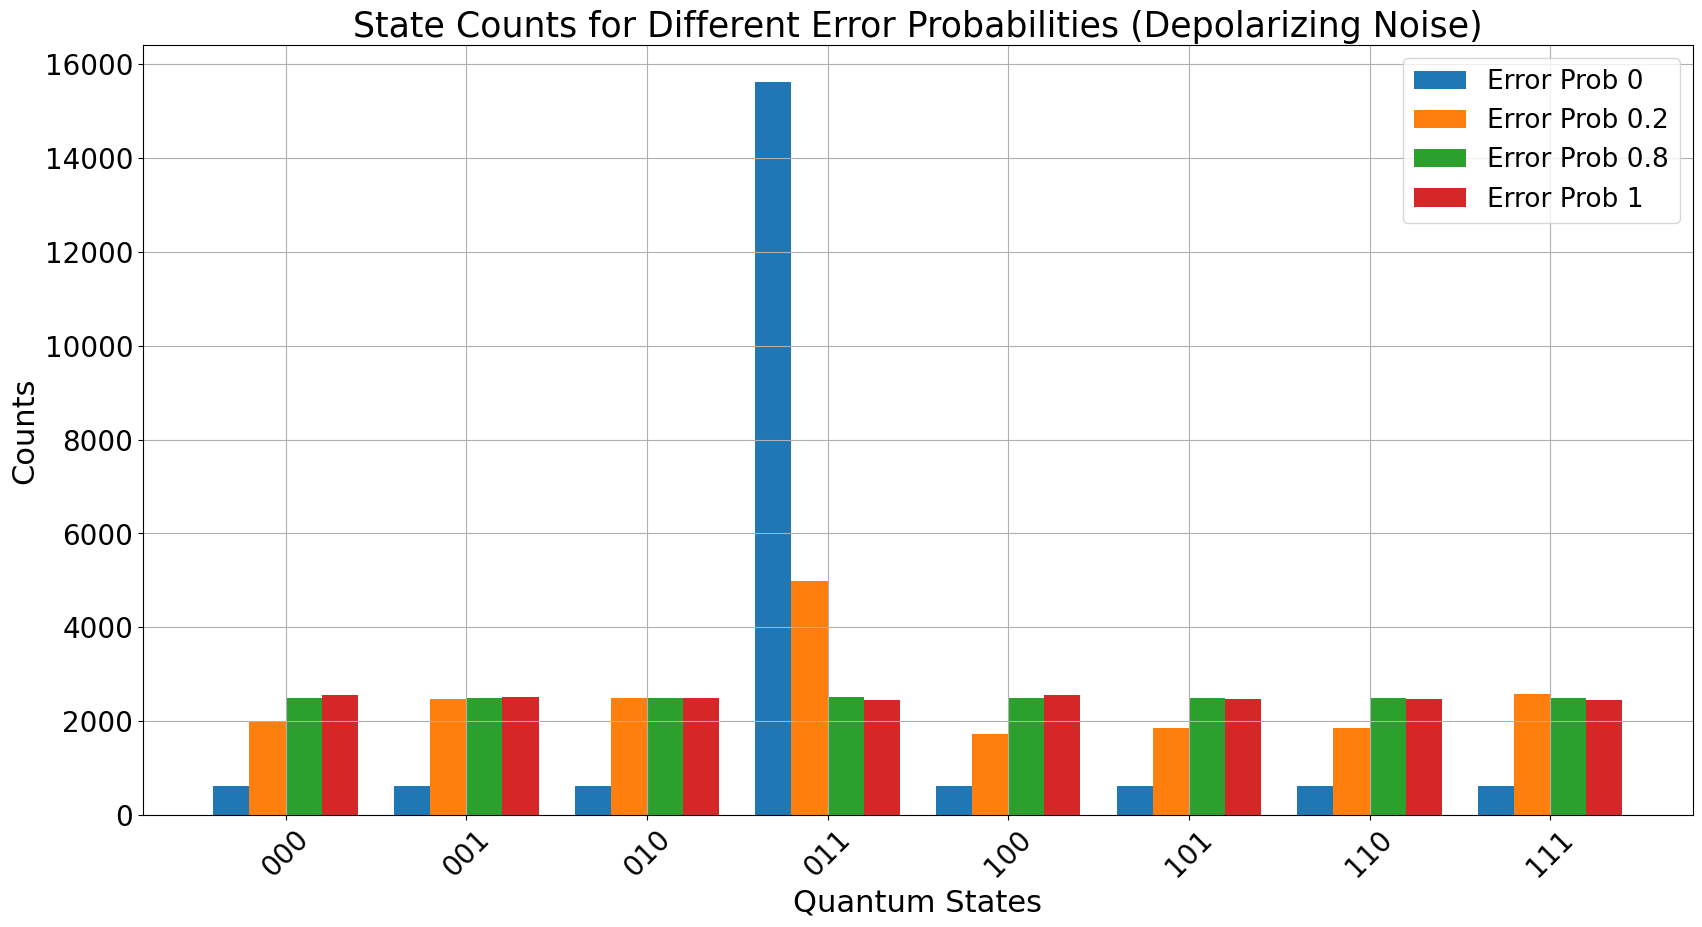

In [42]:
plot_bar_state_counts(NoiseProtocol.DEPOLARIZING)

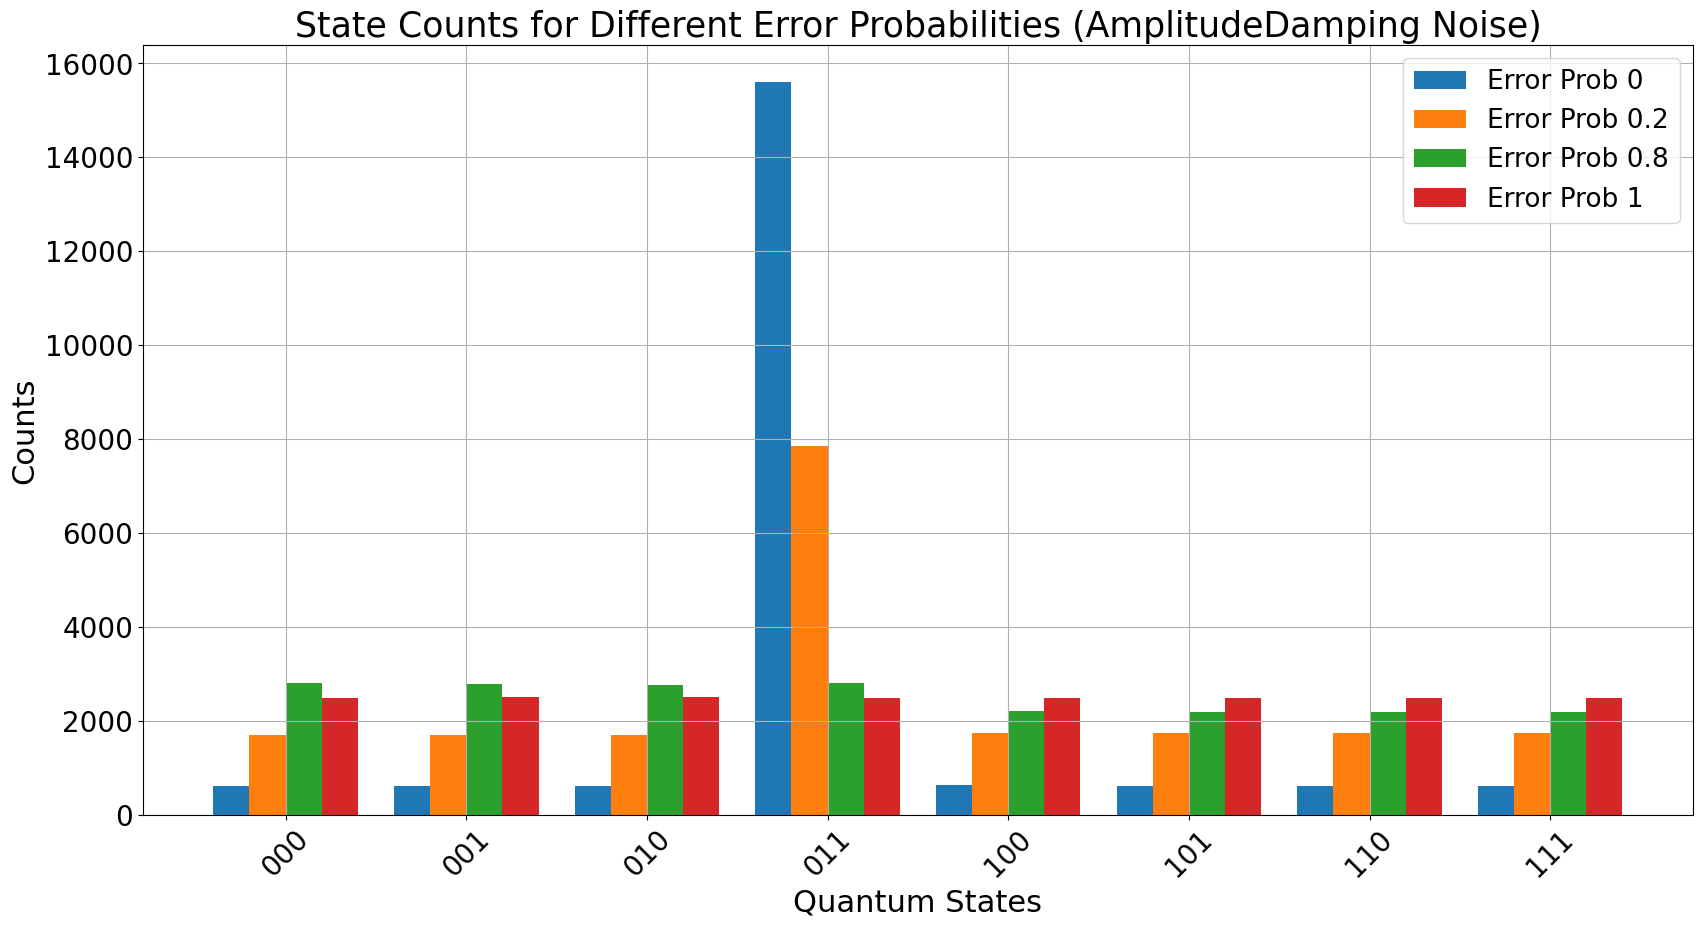

In [43]:
plot_bar_state_counts(NoiseProtocol.AMPLITUDE_DAMPING)

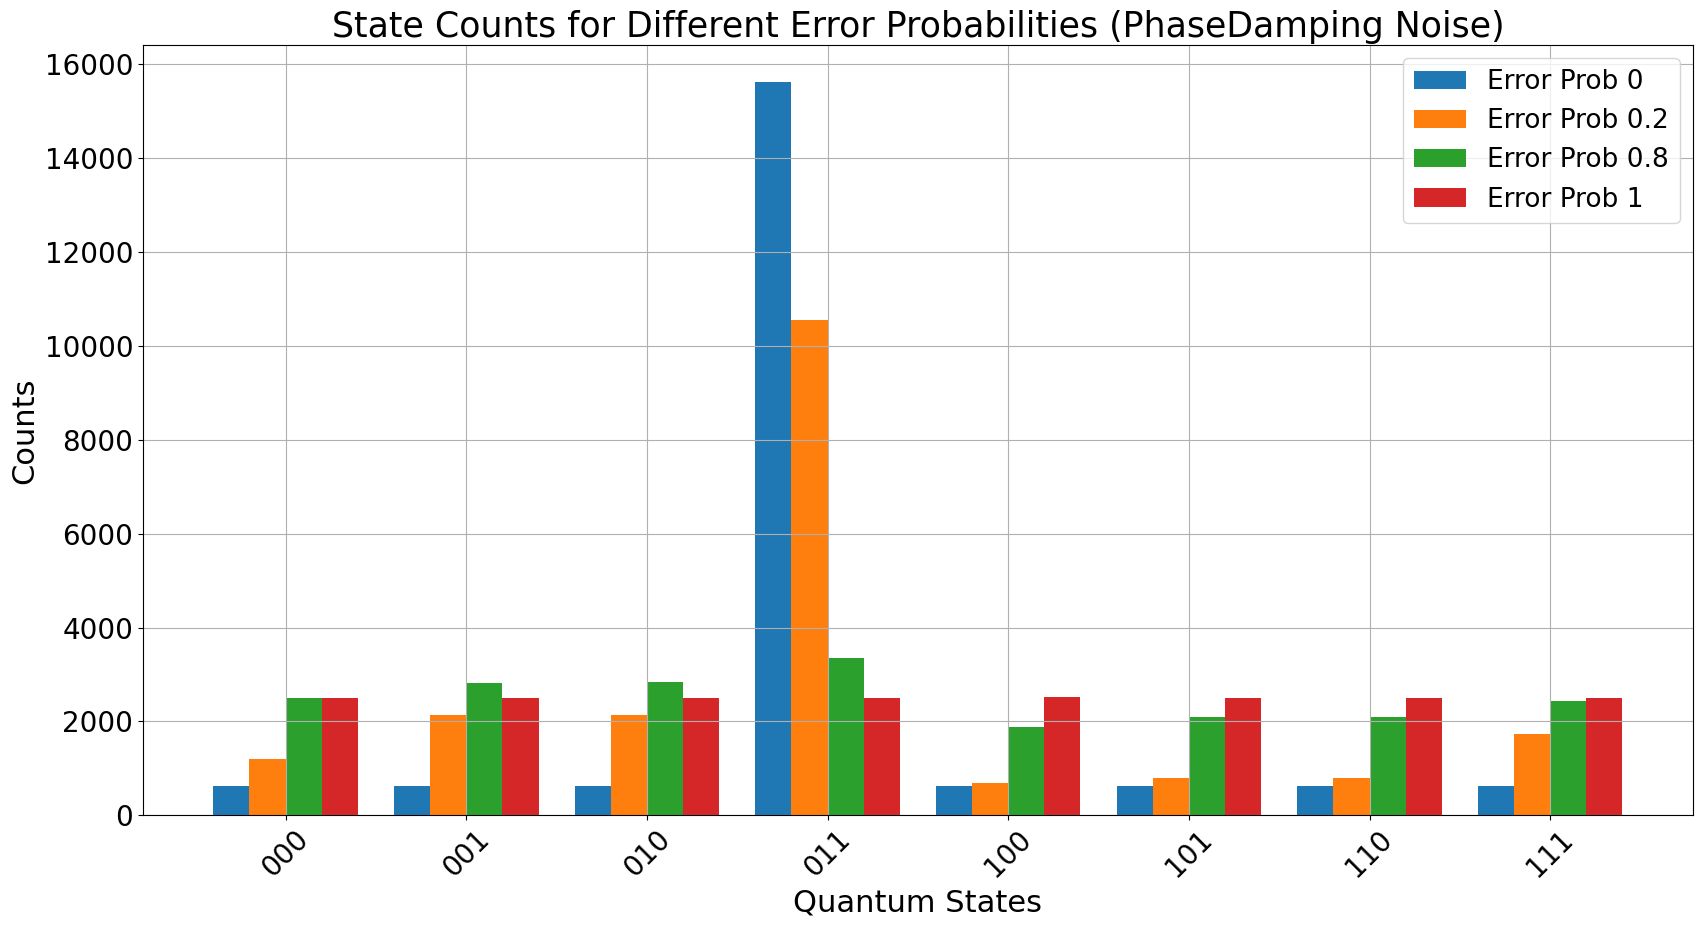

In [44]:
plot_bar_state_counts(NoiseProtocol.PHASE_DAMPING)

## Impact of error probability on state entropy:

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt

def groover_analysis(protocol, error_probs, total_shots=20000, n_samples=50, noise_gate_type='X'):
    def calculate_entropy(dm):
        dm_qutip = qt.Qobj(dm.squeeze())
        return qt.entropy_vn(dm_qutip)
    
    entropies = []
    for error_prob in error_probs:
        circuit = grover_noise(protocol=protocol, error_proba=error_prob)
        circ = QuantumCircuit(n_qubits=3, operations=circuit)
        state_00 = product_state('000')
        dm_out = circ.run(state=state_00)
        entropy_val = calculate_entropy(dm_out)
        entropies.append(entropy_val)

    plt.figure(figsize=(8, 6))
    plt.plot(error_probs, entropies, 'o-', markersize=6)
    plt.xlabel('Error Probability', fontsize=20)
    plt.ylabel('Von Neumann Entropy', fontsize=20)
    plt.title(f'Impact of error probability ({protocol} Noise) on state entropy ', fontsize=20)
    plt.grid(True)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    #plt.show()
    plt.savefig('entropy_proba.pdf', dpi=300, bbox_inches='tight')

error_probs = np.concatenate([np.linspace(0, 0.25, 10), np.linspace(0.25, 0.75, 5), np.linspace(0.75, 1, 10)])

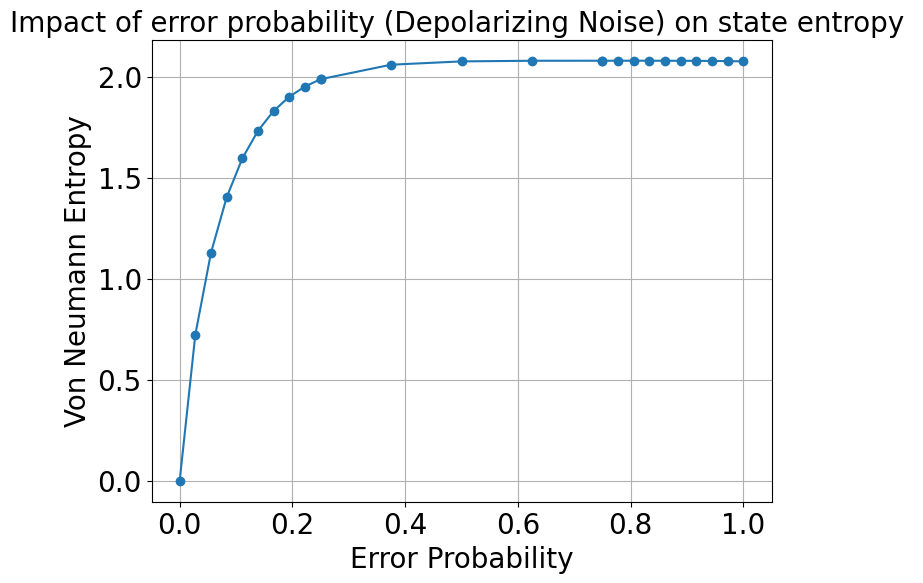

In [46]:
groover_analysis(protocol=NoiseProtocol.DEPOLARIZING, error_probs=error_probs)